In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/pierre/git/bo-on-graph


# Ablation study:
- Influence of context_nodes
- Influence of order
- influence of failtol

In [3]:
import os
import torch
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import argparse
from itertools import product
import utils.config_utils as config_utils
from copy import deepcopy
matplotlib.rcParams.update({'font.size': 22})
supported_labels = [
    "random",
    "local_search",
    "ei",
    "ei_ego_network_1",
    "ei_ego_network_1_old",
    "dfs",
    "bfs",
    "ei_ego_network_2",
    "ei_ego_network_2_no_ard",
]
# cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))
d_color = {"ei_ego_network_1":"#1f77b4", "ei_ego_network_2":"#8c564b", "random":"#ff7f0e",
           "local_search":"#2ca02c", "dfs": "#d62728", "bfs": "#9467bd", "ei_ego_network_1_old":"#e377c2",
           "ei_ego_network_2_no_ard":"#7f7f7f"}
d_label = {"ei_ego_network_1":"BO_Poly", "ei_ego_network_1_old":"BO_SumInverse",
           "ei_ego_network_2":"BO_Diff_ARD", "ei_ego_network_2_no_ard":"BO_Diff", 
           "random":"Random", "local_search":"Local search", "dfs": "Dfs", "bfs": "Bfs"}

list_color = ["#1f77b4","#8c564b", "#ff7f0e", "#2ca02c","#d62728","#9467bd","#e377c2", "#7f7f7f"]


In [4]:
def create_path(save_path, label, problem_name, problem_kwargs, bo_kwargs, tr_kwargs):
    ### Desiderata:
    # - First name of kernel
    # - Second name of the task
    # - Third name of the graph
    # - Fourth different parameters of kernel, task, graph
    # => Results ordered more conveniently
    if problem_name == "diffusion":
        if problem_kwargs["random_graph_type"] == "ba":
            s = "_".join([problem_kwargs["random_graph_type"], f'm-{problem_kwargs["m"]}', f'beta-{problem_kwargs["beta"]}', f'gamma-{problem_kwargs["gamma"]}',
                f'n-{problem_kwargs["n"]}', f'epsilon-{problem_kwargs["epsilon"]}', f'fracinfect-{problem_kwargs["fraction_infected"]}', f'iter-{problem_kwargs["iteration_diffusion"]}'
                ])
        elif problem_kwargs["random_graph_type"] == "ws":
            s = "_".join([problem_kwargs["random_graph_type"], f'k-{problem_kwargs["k"]}', f'p-{problem_kwargs["p"]}', f'beta-{problem_kwargs["beta"]}', f'gamma-{problem_kwargs["gamma"]}',
                f'n-{problem_kwargs["n"]}', f'epsilon-{problem_kwargs["epsilon"]}', f'fracinfect-{problem_kwargs["fraction_infected"]}', f'iter-{problem_kwargs["iteration_diffusion"]}'
                ])
    elif problem_name == "diffusion_real":
        s = "_".join([f'beta-{problem_kwargs["beta"]}', f'gamma-{problem_kwargs["gamma"]}', f'fracinfect-{problem_kwargs["fraction_infected"]}'])
    elif problem_name == "centrality":
        if problem_kwargs["random_graph_type"] == "ba":
            s = "_".join([problem_kwargs["random_graph_type"], problem_kwargs["feature_name"], f'm-{problem_kwargs["m"]}', f'ninit-{problem_kwargs["n_init"]}', f'n-{problem_kwargs["n"]}'])
        if problem_kwargs["random_graph_type"] == "ws":
            s = "_".join([problem_kwargs["random_graph_type"], problem_kwargs["feature_name"], f'k-{problem_kwargs["k"]}', f'p-{problem_kwargs["p"]}', f'ninit-{problem_kwargs["n_init"]}', f'n-{problem_kwargs["n"]}'])
        if problem_kwargs["random_graph_type"] == "real_enron":
            s = "_".join([problem_kwargs["random_graph_type"], problem_kwargs["feature_name"], f'n_init-{problem_kwargs["n_init"]}'])
        if problem_kwargs["random_graph_type"] == "real_twitch":
            s = "_".join([problem_kwargs["random_graph_type"], problem_kwargs["feature_name"], f'n_init-{problem_kwargs["n_init"]}'])
        if problem_kwargs["random_graph_type"] == "real_fb":
            s = "_".join([problem_kwargs["random_graph_type"], problem_kwargs["feature_name"], f'n_init-{problem_kwargs["n_init"]}'])
    elif problem_name == "test_function":
        s = "_".join([problem_kwargs["test_function"], f'noise-{problem_kwargs["noise"]}', f'n-{problem_kwargs["n"]}'])
    elif problem_name == "team_opt":
        s = "_".join([problem_kwargs["random_graph_type"], f'n_skills-{problem_kwargs["n_skills"]}', f'alpha-{problem_kwargs["alpha"]}', f'n_individuals-{problem_kwargs["n_individuals"]}', f'threshold-{problem_kwargs["threshold"]}'])
    
    ##str_bo = [key + "-" + f"{value}" for key, value in bo_kwargs.items() if key not in ["tr_settings", ablation_name]]
    ##str_tr = [key + "-" + f"{value}" for key, value in tr_kwargs.items() if key != ablation_name]
    str_bo = [key + "-" + f"{value}" for key, value in bo_kwargs.items() if key not in ["tr_settings"]]
    str_tr = [key + "-" + f"{value}" for key, value in tr_kwargs.items()]
    s = "_".join([label, problem_name, s] + str_bo + str_tr)
    save_path = os.path.join(save_path, s)
    return save_path

# TODO
- Change plot such that it loops through the right files for congif

In [46]:
def plot_result(ax, label:str, experiment: str, config: str, plot_kwargs: dict = None, median=False, std=False, cumulative=True, regret=True):
    ### Plot result for one algo and one ablation study given in a config file
    # label: algorithm name 

    # load parameters
    config = config_utils.setup(f'config/{config}.yaml')
    
    ### Place where design save_path from config parameters
    save_dir = config["save_dir"]
    
    # Dictionary key to ax legend
    d_key_legen = {"succ_tol": r"succ_tol", "n_nodes_min": r"Q_{min}", "n_init": r"n_{init}", "context_graph_nnode_init": r"$Q_0:$", "fail_tol": r"fail_tol:", "order": r"$\eta:$", "max_radius": r"$\rho_{max}:$", "trust_region_multiplier": r"$\gamma:$"}

    ### Get different  configs
    labels = config["label"]                  # defines the method
    problem_name=config["problem_name"]
    problem_kwargs = config["problem_settings"]
    bo_kwargs = config["bo_settings"]
    tr_kwargs = bo_kwargs["tr_settings"]
    
    ### Make lists for multiple experiments ### Exchange label and ablation parameter here
    list_keys, list_values = [], []
    for key, value in problem_kwargs.items():
        if key != "random_graph_type":
            if type(value) == list:
                list_keys.append(tuple(["pb", key]))
                list_values.append(value)
    for key, value in bo_kwargs.items():
        if type(value) == list:
            list_keys.append(tuple(["bo", key]))
            list_values.append(value)
    for key, value in tr_kwargs.items():
        if type(value) == list:
            list_keys.append(tuple(["tr", key]))
            list_values.append(value)
    problem_kwargs["random_graph_type"] = experiment
    if len(list_values) > 0:
        min_max_len = np.inf
        for index_ablation, t in enumerate(product(*list_values)):
            for i, el in enumerate(t):
                type_param, key = list_keys[i]
                if type_param == "pb":
                    problem_kwargs[key] = el
                elif type_param == "bo":
                    bo_kwargs[key] = el
                elif type_param == "tr":
                    tr_kwargs[key] = el
            save_path = create_path(save_dir, label, problem_name, problem_kwargs, bo_kwargs, tr_kwargs)
            save_path = os.path.join(save_path, label)
            ## Here are in directory with signal png and pt
            plot_kwargs = deepcopy(plot_kwargs) or {}
            data_path_seeds = [f for f in os.listdir(save_path) if ".pt" in f]
            data_over_seeds = []
            for i, df in enumerate(data_path_seeds):
                data_path = os.path.join(save_path, df)
                with open(data_path, "rb") as fp:
                    data = torch.load(data_path, map_location="cpu")
                    minimize = False
                if "regret" in data.keys() and regret:
                    y = -data["regret"].numpy().flatten()   # to maximize negative regret
                    minimize = True
                else:
                    assert "Y" in data.keys()
                    y = data["Y"].numpy().flatten()
                data_over_seeds.append(y)
            n_data_per_trial = np.array([len(d) for d in data_over_seeds])
            
            max_len = max(n_data_per_trial)
            if len(np.unique(n_data_per_trial)) > 1:
                # pad as appropriate
                for i, d in enumerate(data_over_seeds):
                    data_over_seeds[i] = np.concatenate((
                        d, d[-1] * np.ones(max_len - d.shape[0])))
            all_data = np.array(data_over_seeds)
            if cumulative:
                y = pd.DataFrame(all_data).cummax(axis=1)
            else:
                y = pd.DataFrame(all_data)
            x = np.arange(all_data.shape[1])
            if median:
                mean = y.median(axis=0)
                lb = y.quantile(q=0.25, axis=0)
                ub = y.quantile(q=0.75, axis=0)
            elif std:
                mean = y.mean(axis=0)
                # standard error
                lb = mean - y.std(axis=0)
                ub = mean + y.std(axis=0)
            else:
                mean = y.mean(axis=0)
                # standard error
                lb = mean - y.std(axis=0) / np.sqrt(all_data.shape[0])
                ub = mean + y.std(axis=0) / np.sqrt(all_data.shape[0])
            if minimize:
                mean = -mean
                lb = -lb
                ub = -ub

                ax.plot(x, mean, ".-", label=d_key_legen[key] + str(el), color=list_color[index_ablation], **plot_kwargs)
                
            if "alpha" in plot_kwargs.keys():
                del plot_kwargs["alpha"]
            if "markevery" in plot_kwargs.keys():
                del plot_kwargs["markevery"]
            ax.fill_between(x, lb, ub, alpha=0.1, color=list_color[index_ablation], **plot_kwargs)
            min_max_len = min(min_max_len, max_len)
        #ax.legend()
        ax.set_xlabel(r"\#Iters")
        ax.set_ylabel("Regret")
        ax.set_xlim([0, min_max_len])
        ax.grid()
        #plt.yscale("log")
        
        #plt.savefig(os.path.join(exp_dir, "plot_result_regretpng.png"), bbox_inches='tight')
        #plt.savefig(os.path.join(exp_dir, "plot_result_regretpdf.pdf"), bbox_inches='tight')
        #plt.clf()
        #return y, max_len

# Failure tolerance

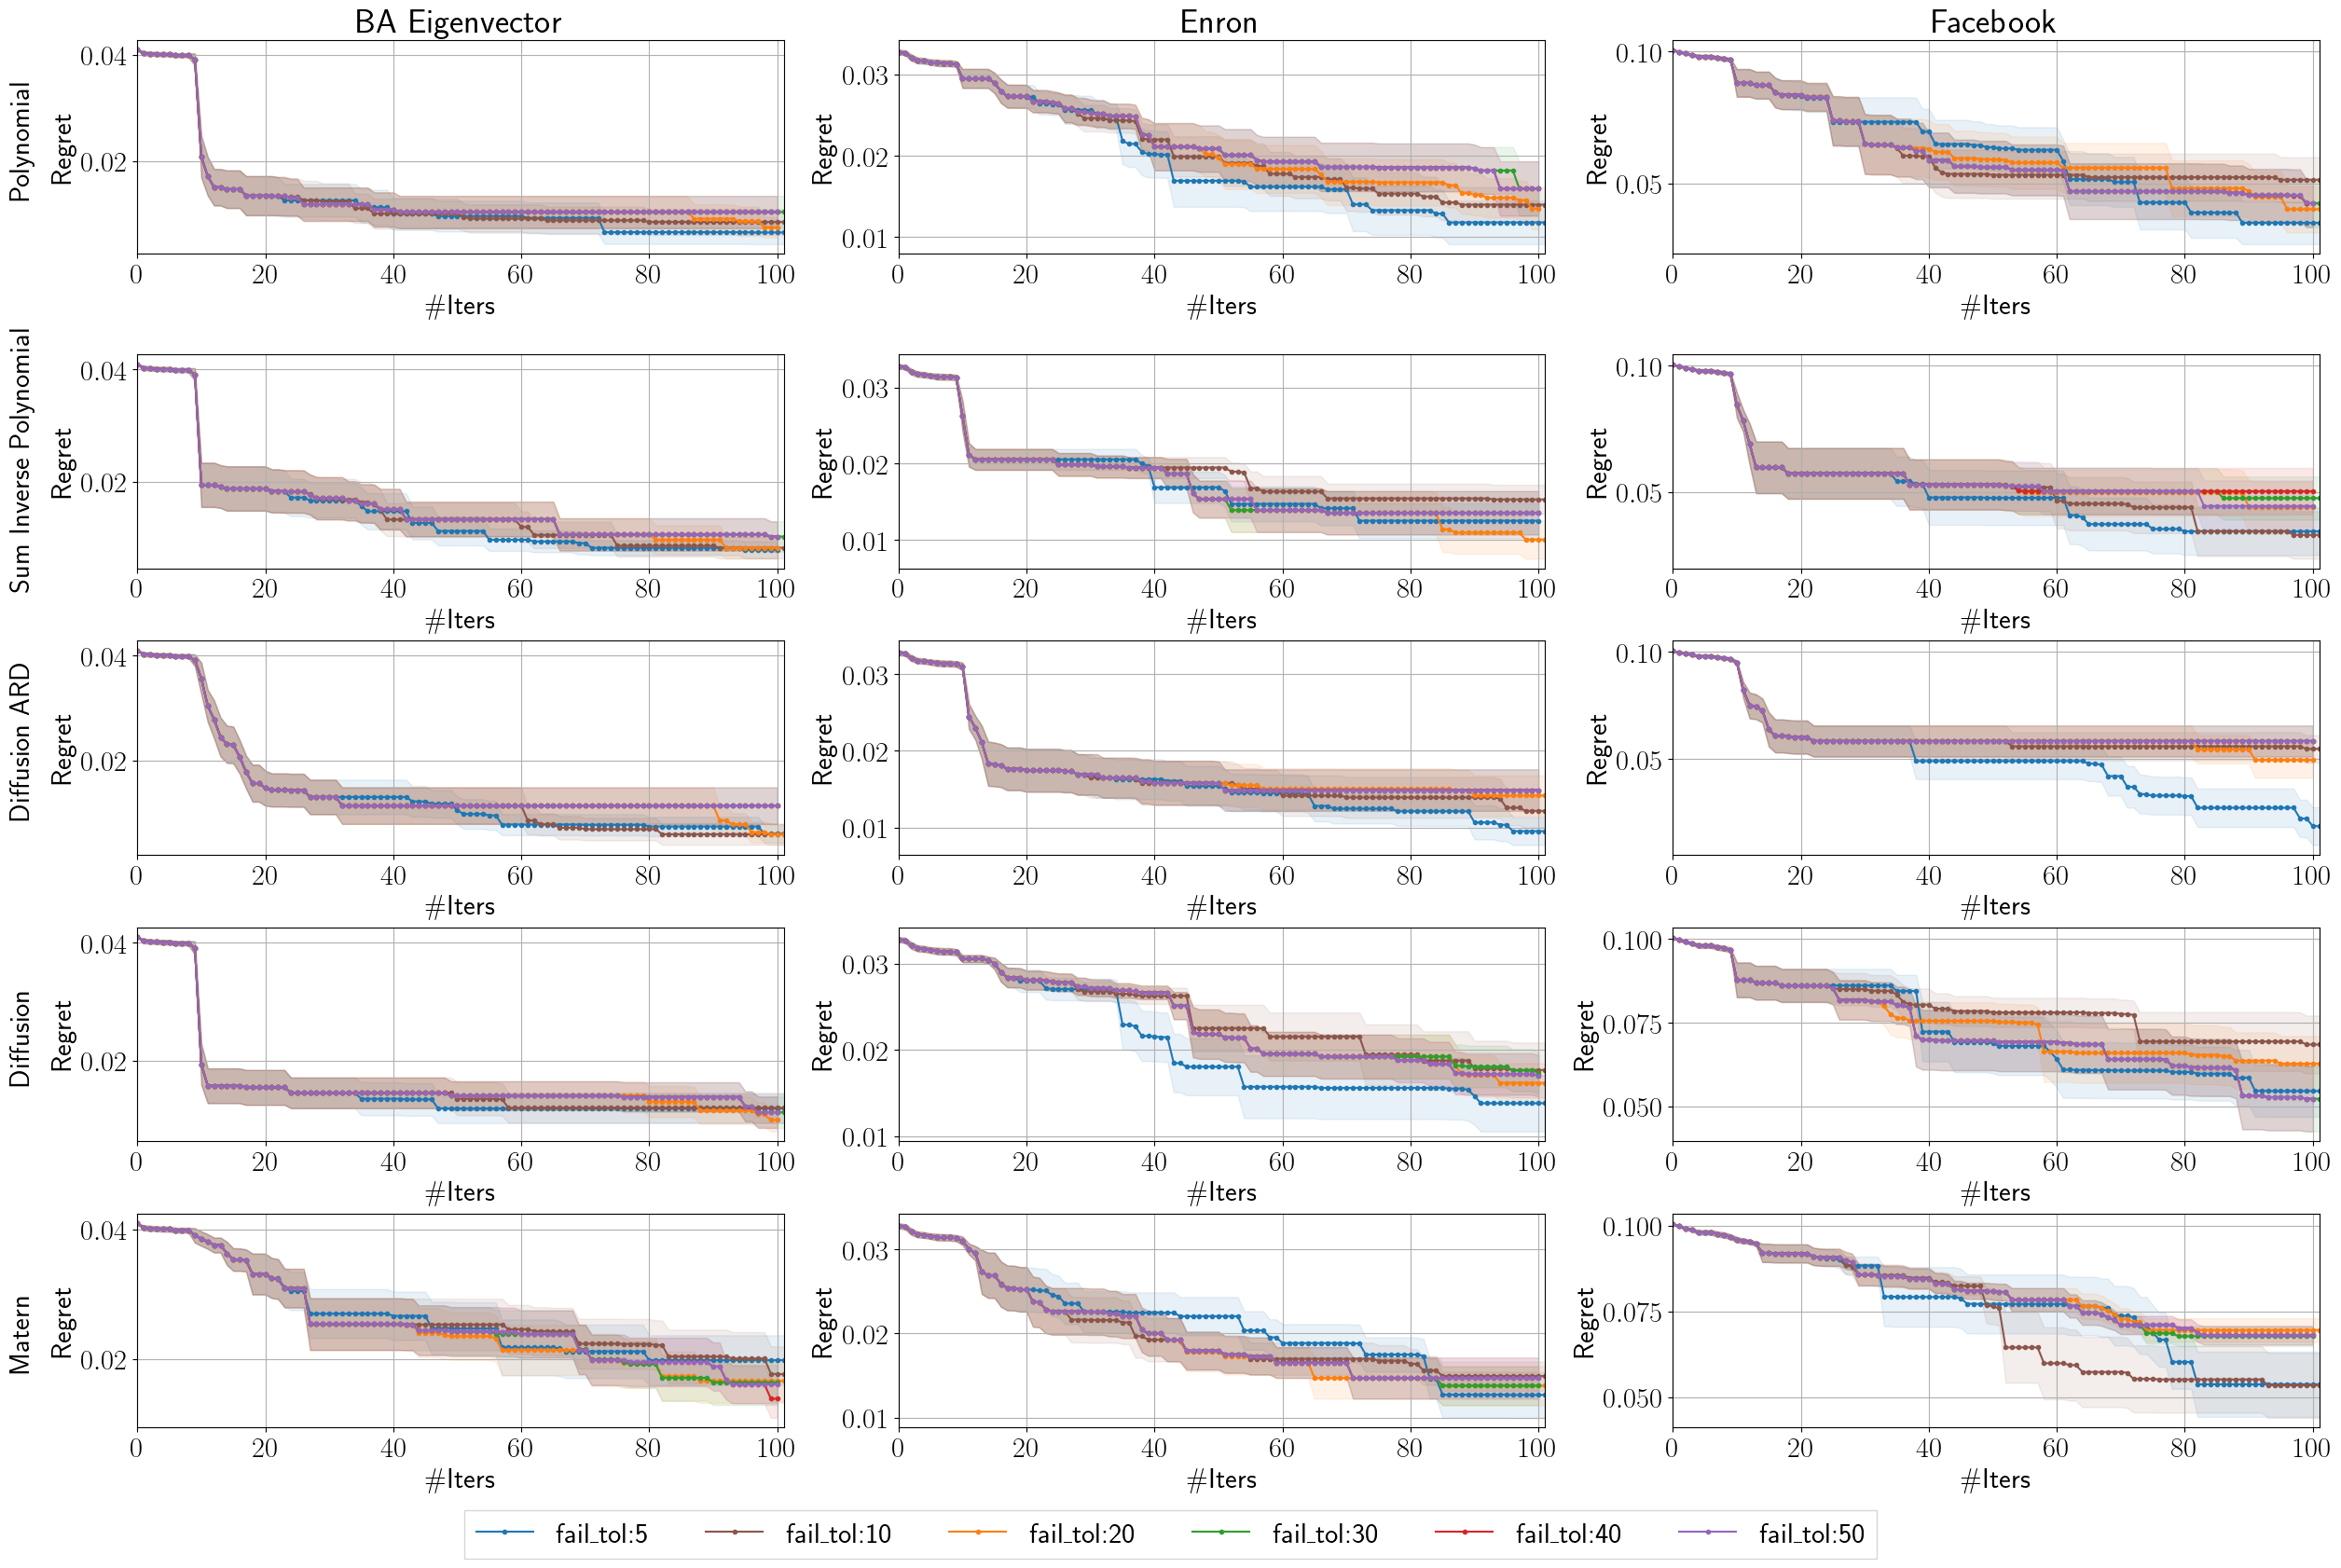

In [33]:
### Three parameters: graphtype, kernel (label), param_name in [fail_tol, context_graph_nnode_init, eta] 
config  = "ablation_fail" ##"ablation_fail", "ablation_gamma", "ablation_ninit", "ablation_Q0", "ablation_Qmin", "ablation_radius", "ablation_succ"
list_algorithms = ["ei_ego_network_1", "ei_ego_network_1_old", "ei_ego_network_2", "ei_ego_network_2_no_ard", "ei_ego_network_matern"]
list_experiences = ["real_enron", "real_fb", "real_twitch"]

plt.rcParams['text.usetex'] = True

n_rows, n_cols = 5, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 16))
for row in range(n_rows):
    for col in range(n_cols):
        algorithm, experience = list_algorithms[row],list_experiences[col]
        plot_result(axs[row, col], label=algorithm, experiment=experience, config=config, std=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('BA Eigenvector')
axs[0, 1].title.set_text('Enron')
axs[0, 2].title.set_text('Facebook')
#axs[0, 3].title.set_text('Twitch')

axs[0, 0].text(-20,0.024,"Polynomial", size=22, verticalalignment='center', rotation=90)
axs[1, 0].text(-20,0.024,"Sum Inverse Polynomial", size=22, verticalalignment='center', rotation=90)
axs[2, 0].text(-20,0.024,"Diffusion ARD", size=22, verticalalignment='center', rotation=90)
axs[3, 0].text(-20,0.024,"Diffusion", size=22, verticalalignment='center', rotation=90)
axs[4, 0].text(-20,0.024,"Matern", size=22, verticalalignment='center', rotation=90)

#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
plt.savefig("plot_result_failpng.png", bbox_inches='tight')
plt.savefig("plot_result_failpdf.pdf", bbox_inches='tight')

# gamma

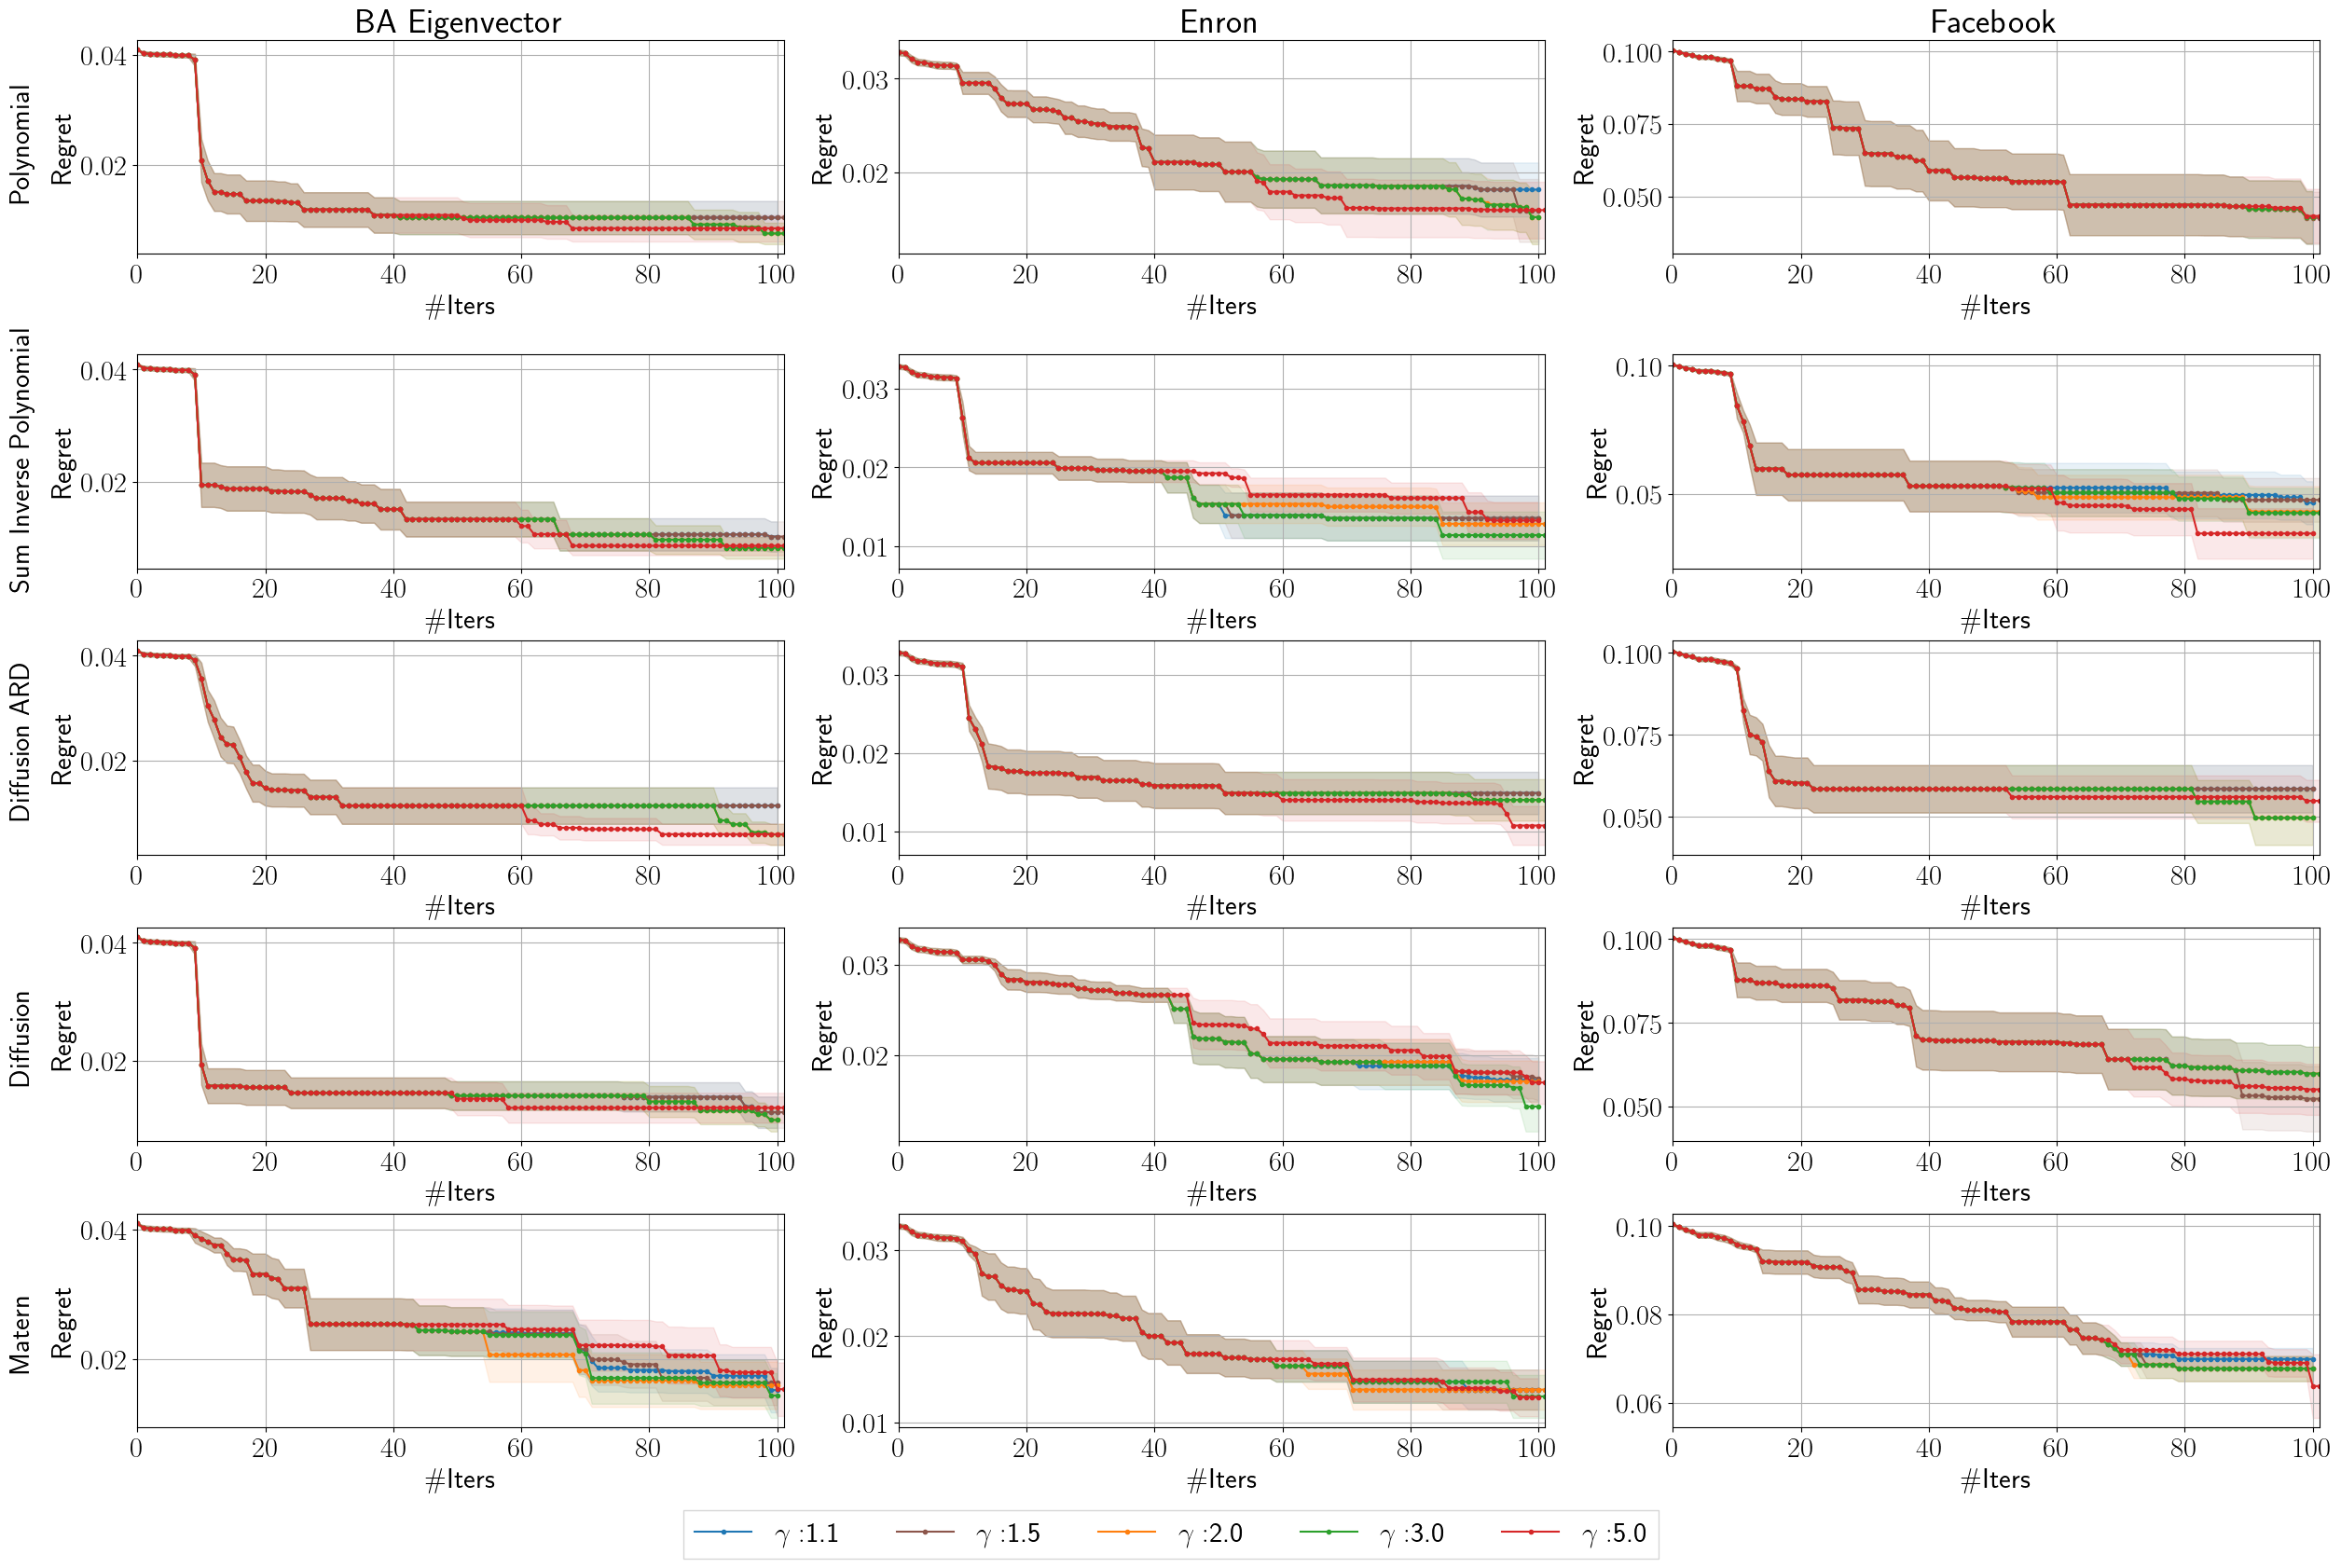

In [34]:
### Three parameters: graphtype, kernel (label), param_name in [fail_tol, context_graph_nnode_init, eta] 
config  = "ablation_gamma" ##"ablation_fail", "ablation_gamma", "ablation_ninit", "ablation_Q0", "ablation_Qmin", "ablation_radius", "ablation_succ"
list_algorithms = ["ei_ego_network_1", "ei_ego_network_1_old", "ei_ego_network_2", "ei_ego_network_2_no_ard", "ei_ego_network_matern"]
list_experiences = ["real_enron", "real_fb", "real_twitch"]

plt.rcParams['text.usetex'] = True

n_rows, n_cols = 5, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 16))
for row in range(n_rows):
    for col in range(n_cols):
        algorithm, experience = list_algorithms[row],list_experiences[col]
        plot_result(axs[row, col], label=algorithm, experiment=experience, config=config, std=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('BA Eigenvector')
axs[0, 1].title.set_text('Enron')
axs[0, 2].title.set_text('Facebook')
#axs[0, 3].title.set_text('Twitch')

axs[0, 0].text(-20,0.024,"Polynomial", size=22, verticalalignment='center', rotation=90)
axs[1, 0].text(-20,0.024,"Sum Inverse Polynomial", size=22, verticalalignment='center', rotation=90)
axs[2, 0].text(-20,0.024,"Diffusion ARD", size=22, verticalalignment='center', rotation=90)
axs[3, 0].text(-20,0.024,"Diffusion", size=22, verticalalignment='center', rotation=90)
axs[4, 0].text(-20,0.024,"Matern", size=22, verticalalignment='center', rotation=90)

#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
plt.savefig("plot_result_gammapng.png", bbox_inches='tight')
plt.savefig("plot_result_gammapdf.pdf", bbox_inches='tight')

# Q0

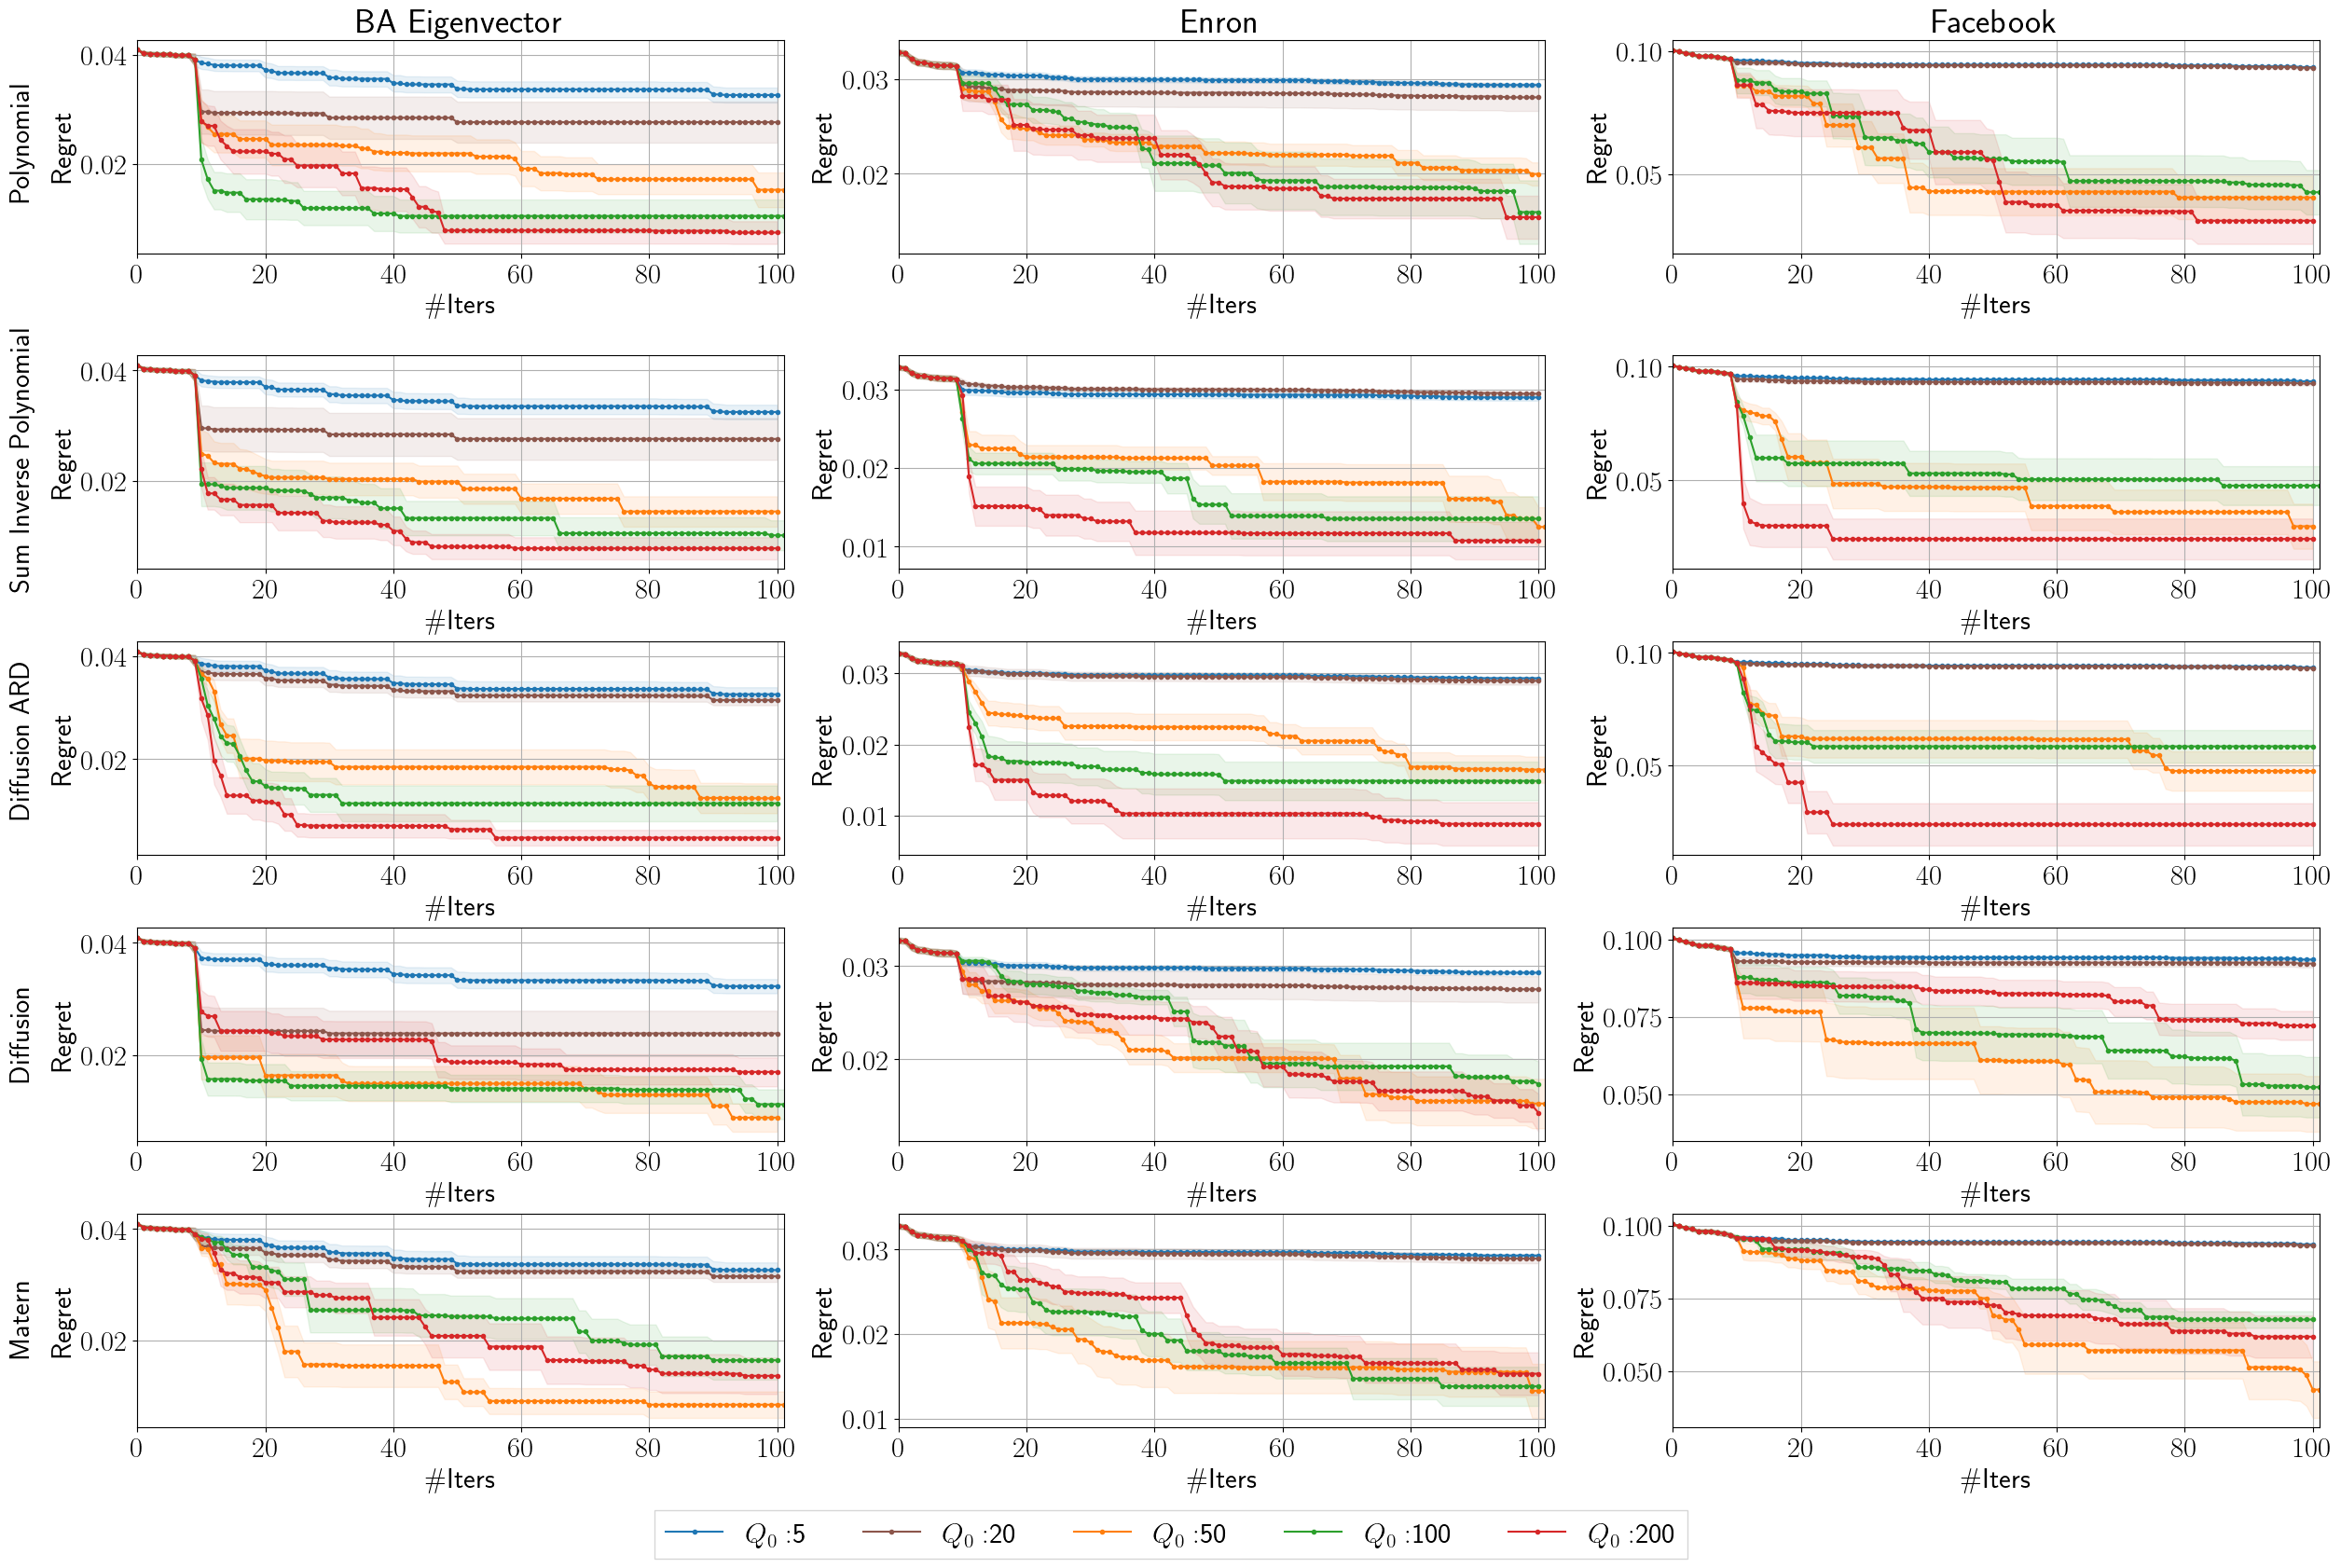

In [43]:
### Three parameters: graphtype, kernel (label), param_name in [fail_tol, context_graph_nnode_init, eta] 
config  = "ablation_Q0" ##"ablation_fail", "ablation_gamma", "ablation_ninit", "ablation_Q0", "ablation_Qmin", "ablation_radius", "ablation_succ"
list_algorithms = ["ei_ego_network_1", "ei_ego_network_1_old", "ei_ego_network_2", "ei_ego_network_2_no_ard", "ei_ego_network_matern"]
list_experiences = ["real_enron", "real_fb", "real_twitch"]

plt.rcParams['text.usetex'] = True

n_rows, n_cols = 5, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 16))
for row in range(n_rows):
    for col in range(n_cols):
        algorithm, experience = list_algorithms[row],list_experiences[col]
        plot_result(axs[row, col], label=algorithm, experiment=experience, config=config, std=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('BA Eigenvector')
axs[0, 1].title.set_text('Enron')
axs[0, 2].title.set_text('Facebook')
#axs[0, 3].title.set_text('Twitch')

axs[0, 0].text(-20,0.024,"Polynomial", size=22, verticalalignment='center', rotation=90)
axs[1, 0].text(-20,0.024,"Sum Inverse Polynomial", size=22, verticalalignment='center', rotation=90)
axs[2, 0].text(-20,0.024,"Diffusion ARD", size=22, verticalalignment='center', rotation=90)
axs[3, 0].text(-20,0.024,"Diffusion", size=22, verticalalignment='center', rotation=90)
axs[4, 0].text(-20,0.024,"Matern", size=22, verticalalignment='center', rotation=90)

#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
plt.savefig("plot_result_Q0png.png", bbox_inches='tight')
plt.savefig("plot_result_Q0pdf.pdf", bbox_inches='tight')

# Qmin

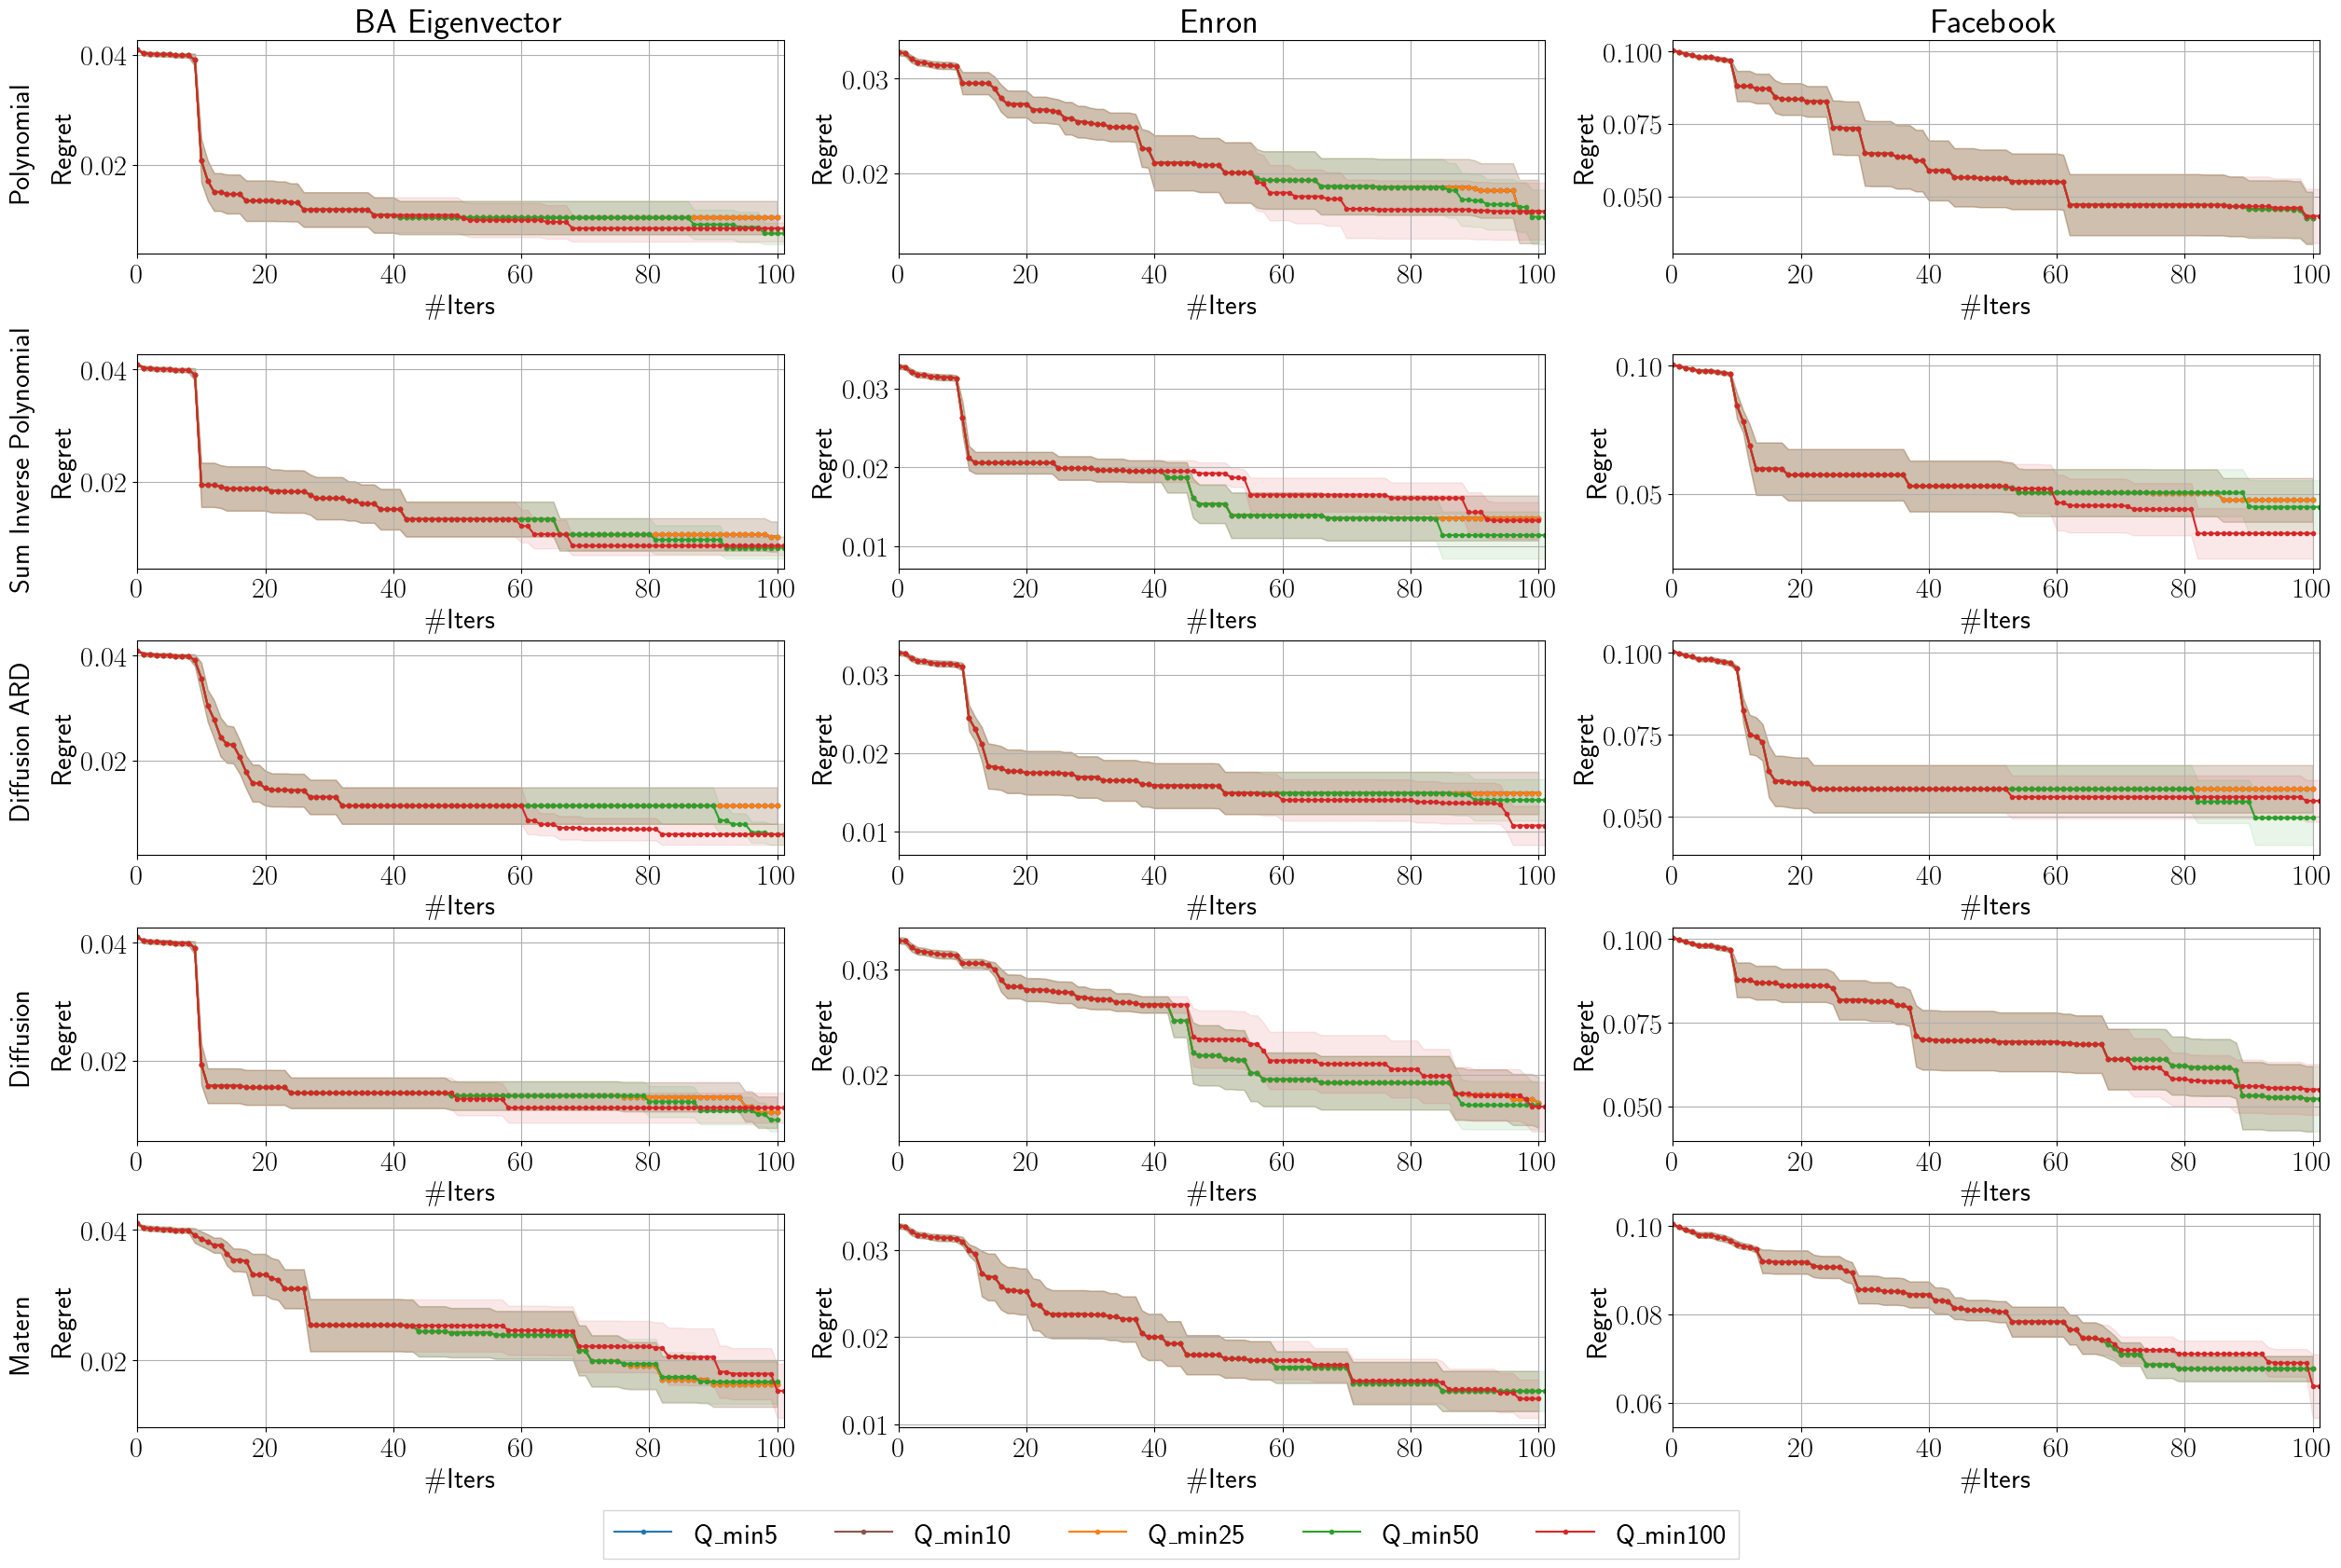

In [42]:
### Three parameters: graphtype, kernel (label), param_name in [fail_tol, context_graph_nnode_init, eta] 
config  = "ablation_Qmin" ##"ablation_fail", "ablation_gamma", "ablation_ninit", "ablation_Q0", "ablation_Qmin", "ablation_radius", "ablation_succ"
list_algorithms = ["ei_ego_network_1", "ei_ego_network_1_old", "ei_ego_network_2", "ei_ego_network_2_no_ard", "ei_ego_network_matern"]
list_experiences = ["real_enron", "real_fb", "real_twitch"]

plt.rcParams['text.usetex'] = True

n_rows, n_cols = 5, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 16))
for row in range(n_rows):
    for col in range(n_cols):
        algorithm, experience = list_algorithms[row],list_experiences[col]
        plot_result(axs[row, col], label=algorithm, experiment=experience, config=config, std=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('BA Eigenvector')
axs[0, 1].title.set_text('Enron')
axs[0, 2].title.set_text('Facebook')
#axs[0, 3].title.set_text('Twitch')

axs[0, 0].text(-20,0.024,"Polynomial", size=22, verticalalignment='center', rotation=90)
axs[1, 0].text(-20,0.024,"Sum Inverse Polynomial", size=22, verticalalignment='center', rotation=90)
axs[2, 0].text(-20,0.024,"Diffusion ARD", size=22, verticalalignment='center', rotation=90)
axs[3, 0].text(-20,0.024,"Diffusion", size=22, verticalalignment='center', rotation=90)
axs[4, 0].text(-20,0.024,"Matern", size=22, verticalalignment='center', rotation=90)

#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
plt.savefig("plot_result_Qminpng.png", bbox_inches='tight')
plt.savefig("plot_result_Qminpdf.pdf", bbox_inches='tight')

# Success tol

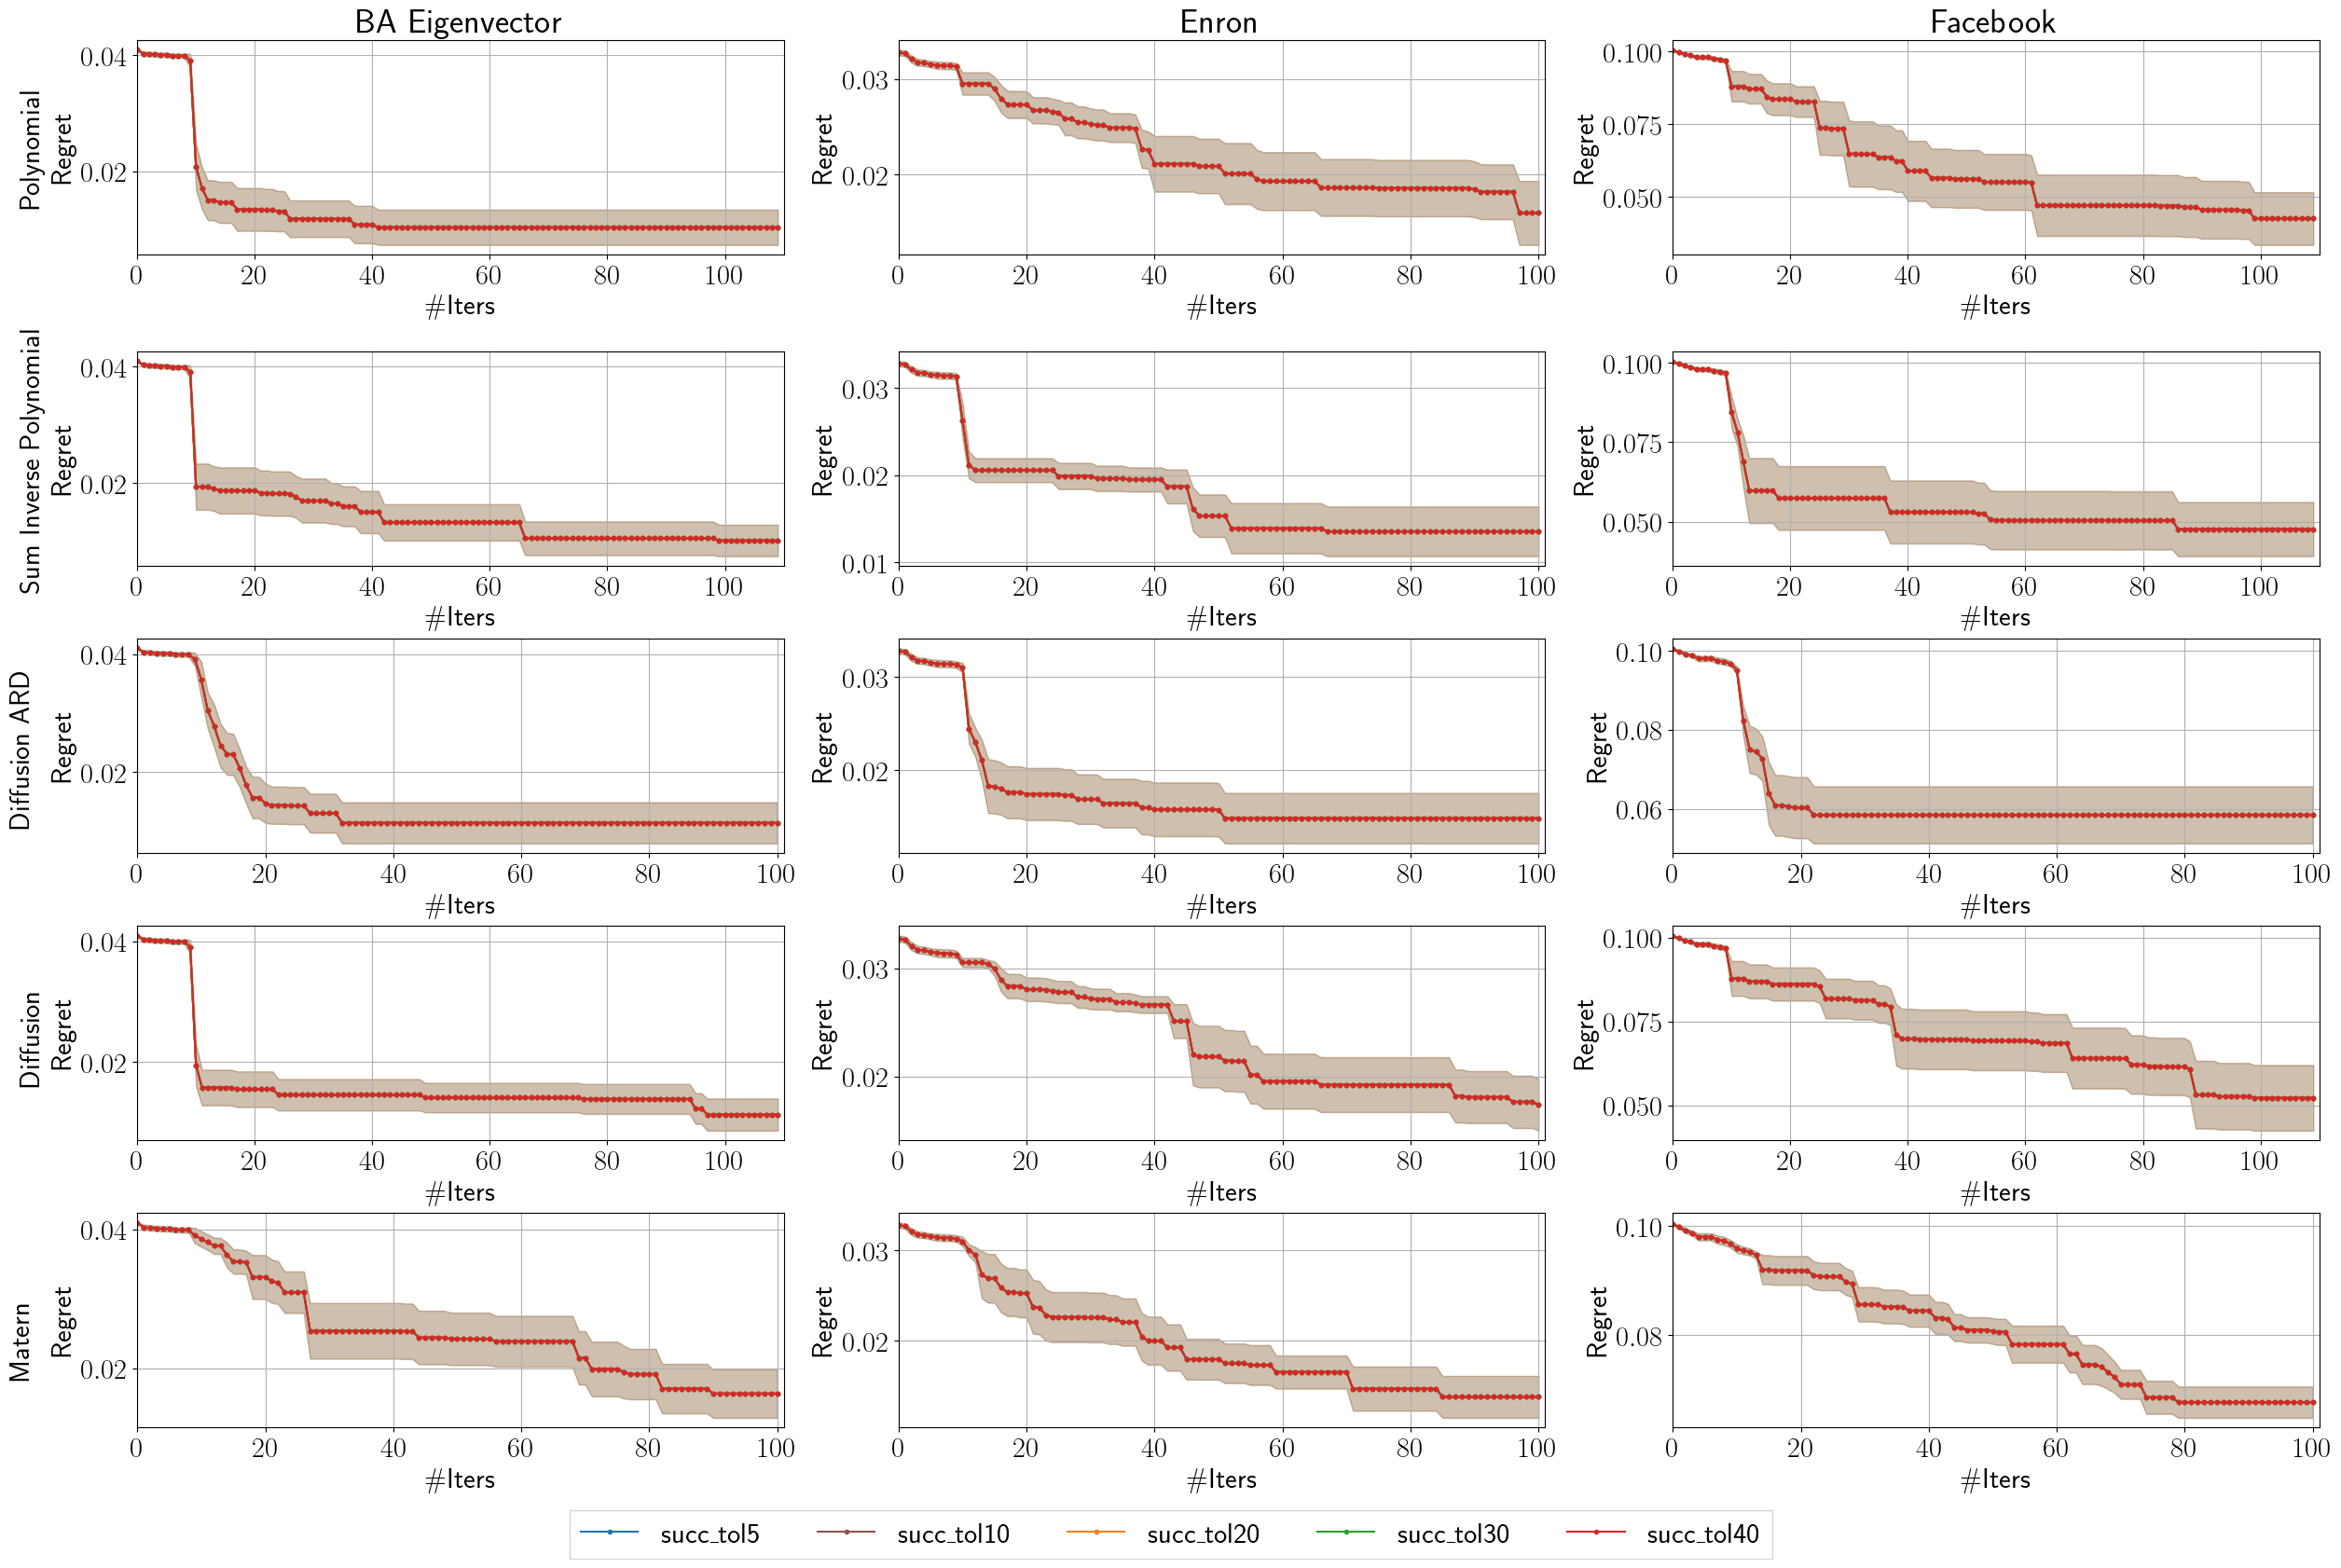

In [47]:
### Three parameters: graphtype, kernel (label), param_name in [fail_tol, context_graph_nnode_init, eta] 
config  = "ablation_succ" ##"ablation_fail", "ablation_gamma", "ablation_ninit", "ablation_Q0", "ablation_Qmin", "ablation_radius", "ablation_succ"
list_algorithms = ["ei_ego_network_1", "ei_ego_network_1_old", "ei_ego_network_2", "ei_ego_network_2_no_ard", "ei_ego_network_matern"]
list_experiences = ["real_enron", "real_fb", "real_twitch"]

plt.rcParams['text.usetex'] = True

n_rows, n_cols = 5, 3
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(25, 16))
for row in range(n_rows):
    for col in range(n_cols):
        algorithm, experience = list_algorithms[row],list_experiences[col]
        plot_result(axs[row, col], label=algorithm, experiment=experience, config=config, std=False)

handles, labels = axs[0, 0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('BA Eigenvector')
axs[0, 1].title.set_text('Enron')
axs[0, 2].title.set_text('Facebook')
#axs[0, 3].title.set_text('Twitch')

axs[0, 0].text(-20,0.024,"Polynomial", size=22, verticalalignment='center', rotation=90)
axs[1, 0].text(-20,0.024,"Sum Inverse Polynomial", size=22, verticalalignment='center', rotation=90)
axs[2, 0].text(-20,0.024,"Diffusion ARD", size=22, verticalalignment='center', rotation=90)
axs[3, 0].text(-20,0.024,"Diffusion", size=22, verticalalignment='center', rotation=90)
axs[4, 0].text(-20,0.024,"Matern", size=22, verticalalignment='center', rotation=90)

#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
plt.savefig("plot_result_succpng.png", bbox_inches='tight')
plt.savefig("plot_result_succpdf.pdf", bbox_inches='tight')

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3


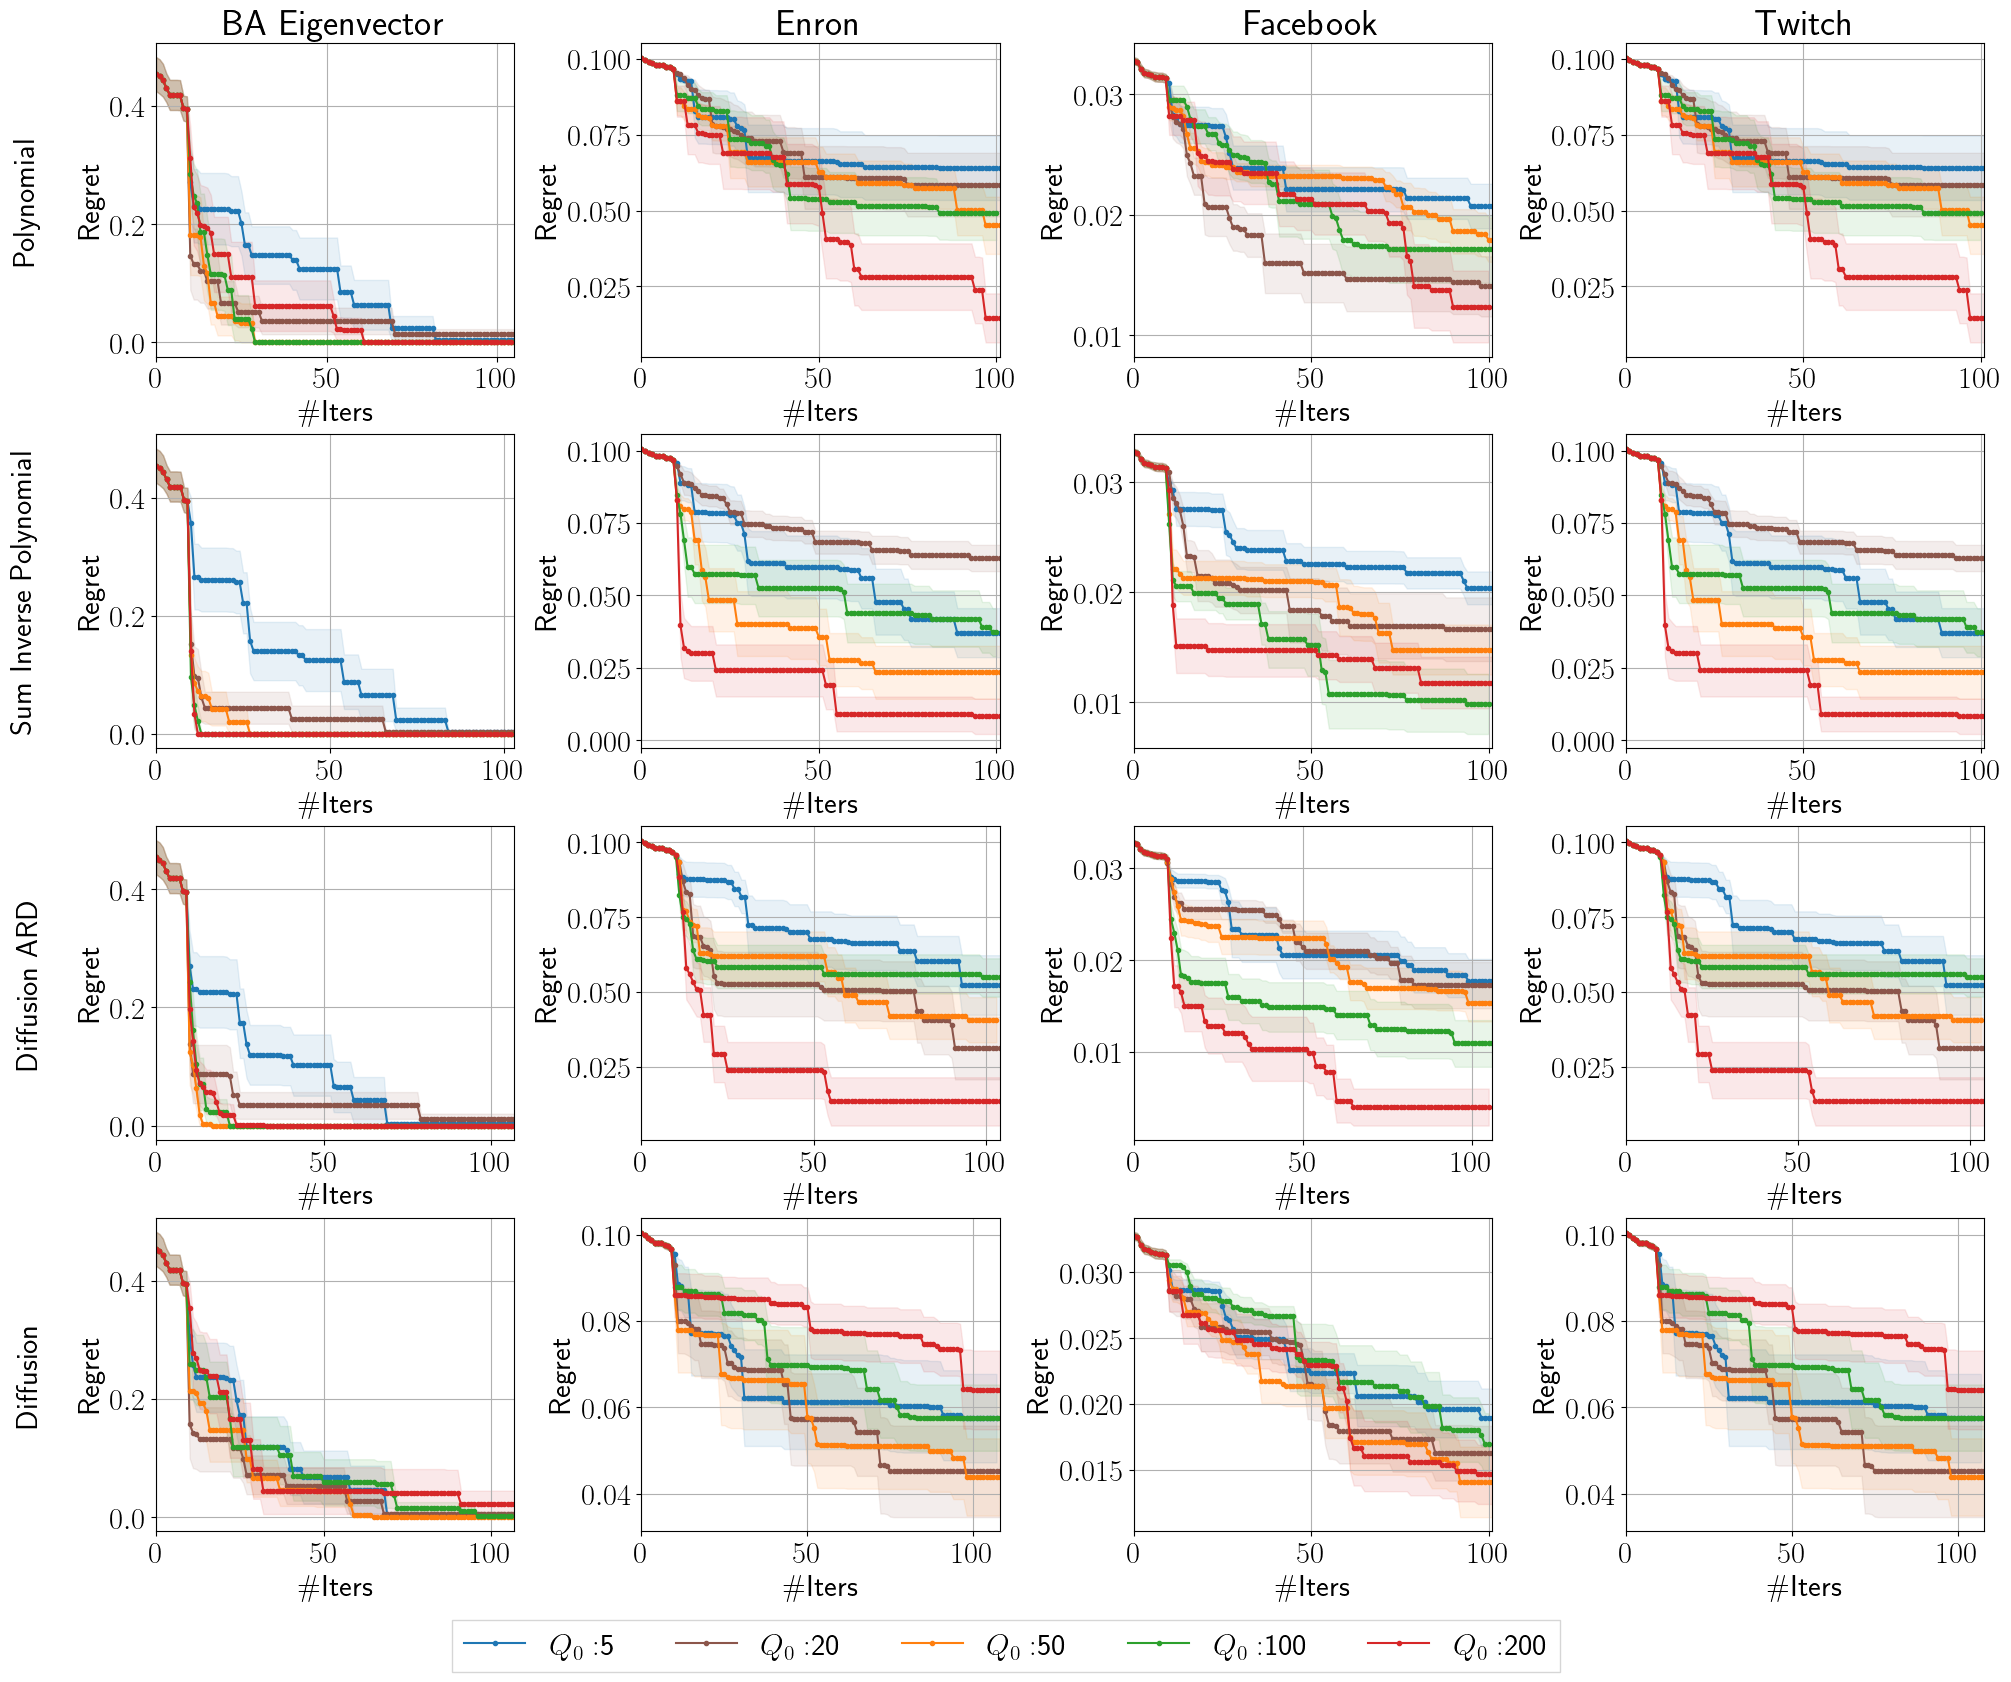

In [ ]:
### Three parameters: graphtype, kernel (label), param_name in [fail_tol, context_graph_nnode_init, eta] 

list_experiences = [("ei_ego_network_1", "ablation_context_ba"), ("ei_ego_network_1", "ablation_context_enron"), ("ei_ego_network_1", "ablation_context_fb"), ("ei_ego_network_1", "ablation_context_twitch"),
                    ("ei_ego_network_1_old", "ablation_context_ba"),("ei_ego_network_1_old", "ablation_context_enron"),("ei_ego_network_1_old", "ablation_context_fb"), ("ei_ego_network_1_old", "ablation_context_twitch"),
                    ("ei_ego_network_2", "ablation_context_ba"), ("ei_ego_network_2", "ablation_context_enron"), ("ei_ego_network_2", "ablation_context_fb"), ("ei_ego_network_2", "ablation_context_twitch"),
                    ("ei_ego_network_2_no_ard", "ablation_context_ba"), ("ei_ego_network_2_no_ard", "ablation_context_enron"), ("ei_ego_network_2_no_ard", "ablation_context_fb"), ("ei_ego_network_2_no_ard", "ablation_context_twitch")]

n_rows, n_cols = 4, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 16))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    label, config = experience
    plot_result(axs[idx_row, idx_col], label=label, config=config, std=False)


handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('BA Eigenvector')
axs[0, 1].title.set_text('Enron')
axs[0, 2].title.set_text('Facebook')
axs[0, 3].title.set_text('Twitch')

axs[0, 0].text(-42,0.24,"Polynomial", size=22, verticalalignment='center', rotation=90)
axs[1, 0].text(-42,0.24,"Sum Inverse Polynomial", size=22, verticalalignment='center', rotation=90)
axs[2, 0].text(-42,0.24,"Diffusion ARD", size=22, verticalalignment='center', rotation=90)
axs[3, 0].text(-42,0.24,"Diffusion", size=22, verticalalignment='center', rotation=90)

#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=8)
#plt.legend()
plt.savefig("plot_result_contextpng.png", bbox_inches='tight')
plt.savefig("plot_result_contextpdf.pdf", bbox_inches='tight')

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3


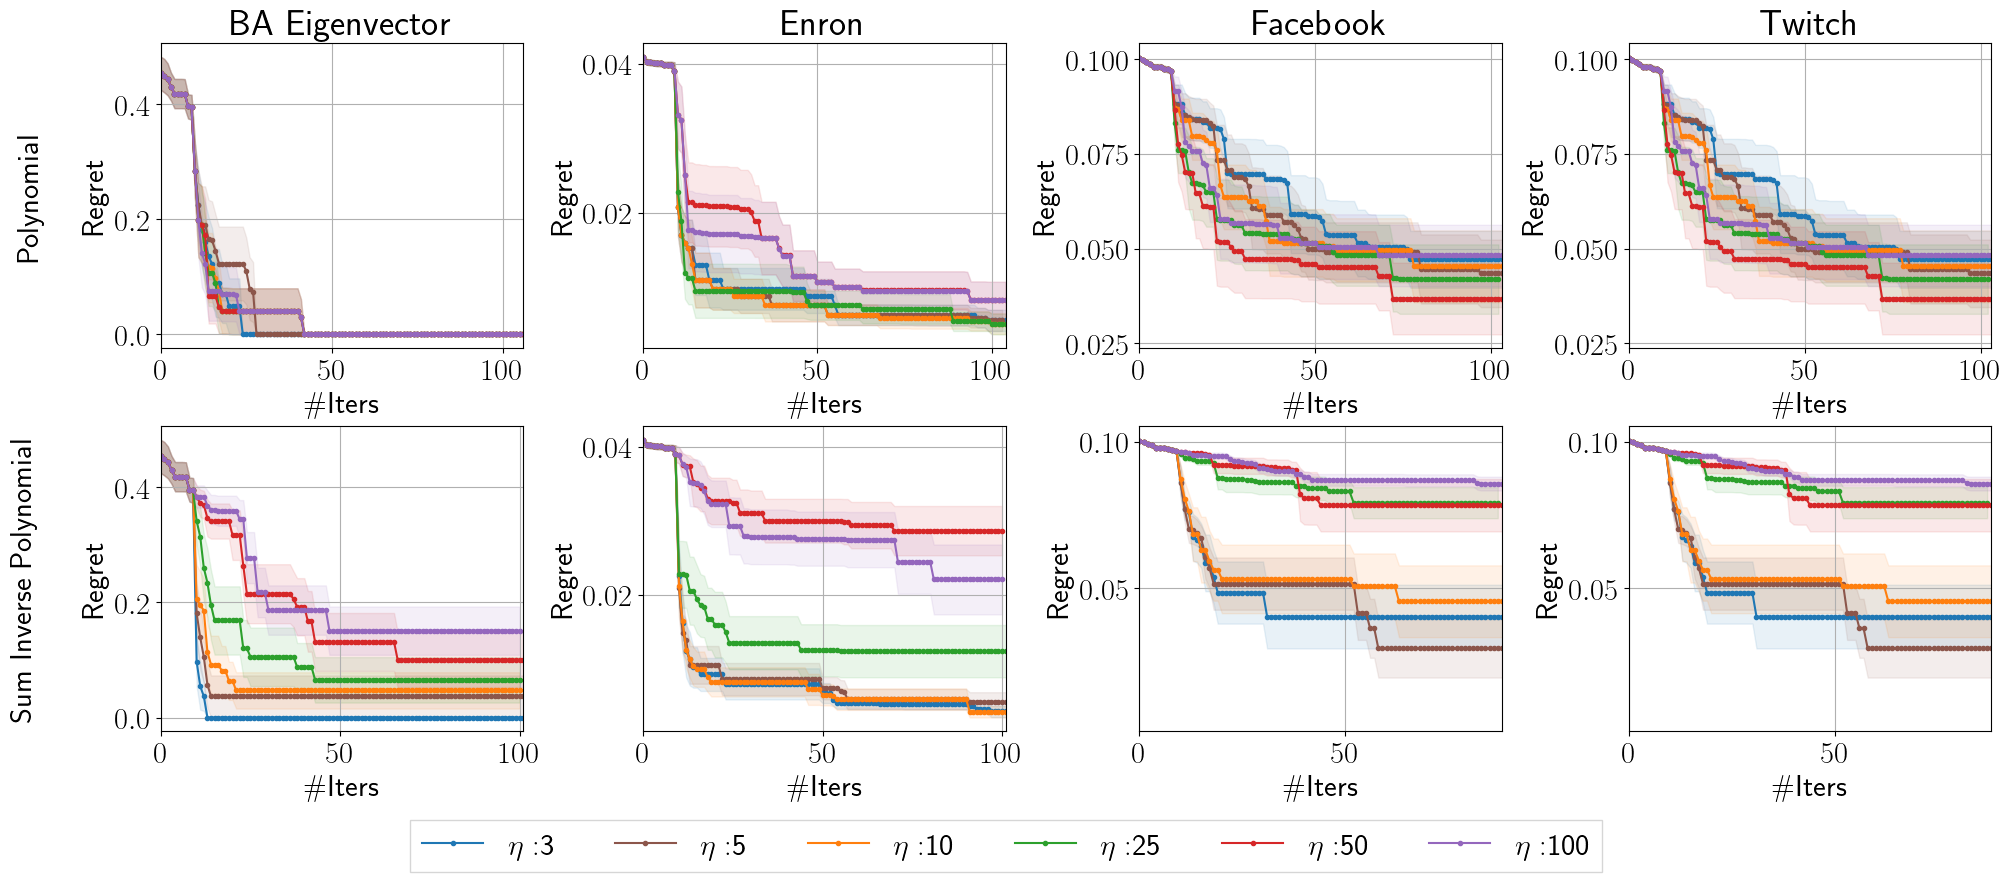

In [9]:
### Three parameters: graphtype, kernel (label), param_name in [fail_tol, context_graph_nnode_init, eta] 

list_experiences = [("ei_ego_network_1", "ablation_eta_ba"), ("ei_ego_network_1", "ablation_eta_enron"), ("ei_ego_network_1", "ablation_eta_fb"), ("ei_ego_network_1", "ablation_eta_twitch"),
                    ("ei_ego_network_1_old", "ablation_eta_ba"),("ei_ego_network_1_old", "ablation_eta_enron"),("ei_ego_network_1_old", "ablation_eta_fb"), ("ei_ego_network_1_old", "ablation_eta_twitch")]

n_rows, n_cols = 2, 4
#fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))
for i, experience in enumerate(list_experiences):
    idx_row, idx_col = i // n_cols, i % n_cols
    print(idx_row, idx_col)
    label, config = experience
    plot_result(axs[idx_row, idx_col], label=label, config=config, std=False)


handles, labels = axs[idx_row, idx_col].get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
axs[0, 0].title.set_text('BA Eigenvector')
axs[0, 1].title.set_text('Enron')
axs[0, 2].title.set_text('Facebook')
axs[0, 3].title.set_text('Twitch')

axs[0, 0].text(-42,0.24,"Polynomial", size=22, verticalalignment='center', rotation=90)
axs[1, 0].text(-42,0.24,"Sum Inverse Polynomial", size=22, verticalalignment='center', rotation=90)

#axs[1, 1].legend(handles = handles , labels=labels,loc='upper center', 
#             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=4)
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, 0.),fancybox=False, shadow=False, ncol=6)
#plt.legend()
plt.savefig("plot_result_etapng.png", bbox_inches='tight')
plt.savefig("plot_result_etapdf.pdf", bbox_inches='tight')

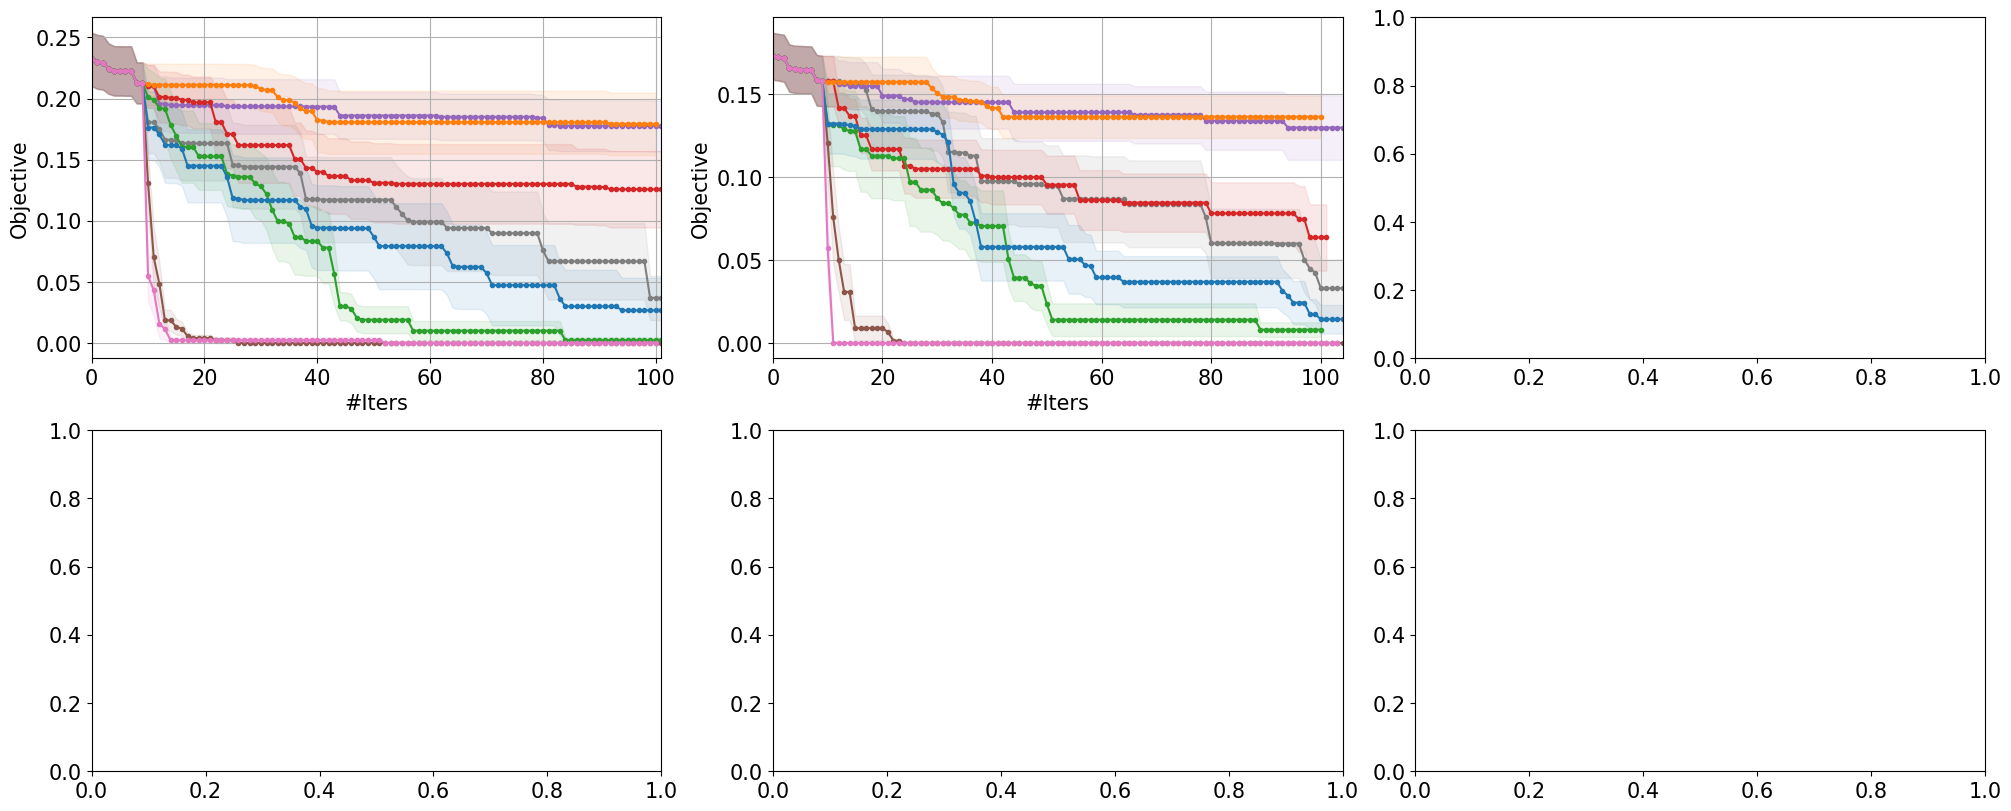

In [62]:
list_experiences = ["ba_betweenness_m-2_ninit-20_n-1000", "ba_betweenness_m-3_ninit-20_n-1000", "ba_betweenness_m-4_ninit-20_n-1000",
                    "ba_eigenvector_centrality_m-2_ninit-20_n-1000", "ba_eigenvector_centrality_m-3_ninit-20_n-1000", "ba_eigenvector_centrality_m-4_ninit-20_n-1000"]
n_rows, n_cols = 2, 3
fig, axs = plt.subplots(n_rows, n_cols, layout='constrained', figsize=(20, 8))


plot_result(axs[0, 0], "./logs/centrality/", list_experiences[0], std=False)

plot_result(axs[0, 1], "./logs/centrality/", list_experiences[1], std=False)

#handles, labels = subfigs[idx_row, idx_col].gca().get_legend_handles_labels()
#fig.legend(handles, labels, loc='center')
#plt.legend()
#plt.show()


In [53]:
subfigs[0,1].gca()

<Axes: xlabel='#Iters', ylabel='Objective'>

In [17]:
subfigs[0, 0].gca()

<Axes: >

In [6]:
subfigs[0,0]